# Soil Moisture Percentiles using Quantiles



In this section, for a given location with latitude and longitude (lat, lon), and a given day (d) of a year (y), the daily 30th and 10th percentiles of soil moisture are constructed. A 5 day window, (d-6, d-3, d, d+3, d+6), is used to construct the distrubution of the two quantiles over a selected period.

The quantiles vary across the period and are plotted together with the actual root zone soil moisture fraction/degree of saturation (W), in order to identify where flash droughts occur. 


Furthermore, this is tested using an empirical cumulative distribution function (CDF), with the same window, to convert W into a daily percentile, to see when and where it drops from above 30% to 10% in 20 days over a selected period. This is done to compare methods and validity. 

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pandas as pd
import dask.distributed as dsk

# Start Client/ dask runs together with xarray to improve performance. Only need to initialize once here.
clnt = dsk.Client()
clnt

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33965 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33965/status,
Dashboard: /proxy/33965/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38915,Workers: 4
Dashboard: /proxy/33965/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:35629,Total threads: 1
Dashboard: /proxy/37883/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:40913,


In [2]:
# path to directory of AWRA model data
awra_dir = '/g/data/fj8/BoM/AWRA/DATA/'

In [3]:
# extracting all files of sm_pct data. * tells you to take all similar files, here starting with 1(1980 etc) and 2(2022 etc)
# degree of saturation/soil moisture root zone(0-100cm) fraction (W)
sm_files = 'SCHEDULED-V6/processed/values/day/sm_pct_[1-2]*.nc'

#open a multifile dataset, from the same directory
ds_sm = xr.open_mfdataset(awra_dir + sm_files)

# selecting a time slice and specific latitude and longitude to work on a single grid cell
time_slice = slice('1980-01-01', '2022-12-31')
lat_sel = -30
lon_sel = 145

# data at a grid point and a specific time
da_sm = ds_sm.sel(latitude = lat_sel, longitude = lon_sel, time = time_slice)
da_sm = da_sm.load()

# array of W
W = da_sm['sm_pct']

In [4]:
# using sm dataset to create a list of 6 days before, 3 days before, the day, 3 days after and 6 days after 
da_sm_6days_bef = da_sm.shift(time = -6) #after
da_sm_3days_bef = da_sm.shift(time = -3)
da_sm_6days_after = da_sm.shift(time = 6) #before
da_sm_3days_after = da_sm.shift(time = 3)

# 5 day window
da_list = [da_sm_6days_bef, da_sm_3days_bef, da_sm, da_sm_3days_after, da_sm_6days_after]

#concatate the data to create a dimension called window, which includes the 5 days in the list above
da_sm_withWindow = xr.concat(da_list, dim = 'window')

In [5]:
# using the window created above to calculate quantiles to identify FD
# create empty lists to save the calculated quantiles
list_da_quant = [] #for quantiles
list_doy = [] # for day of year

# for each doy, sample in the new dataset,now including the window, grouped by day of year
# create a list of the quantiles 0.1, 0.3 for each doy, using this window
for doy, sample in da_sm_withWindow.groupby('time.dayofyear'):
    da_quant_bydoy = sample.load().quantile([0.1, 0.3], dim=['time', 'window']) #sample. stores the quantiles in da_quant_bydoy for da_sm_withWindow. Need to keep definition of dimension for when working on larger datasets
    list_doy.append(doy) #.append adds items to list 
    list_da_quant.append(da_quant_bydoy)

In [6]:
# list_da_quant contains 366 elements - check with len(), with two quantile dimensions
# concatenate the data to create anotehr dimension named dayofyear from list_doy
ds_sm_pct_perc = xr.concat(list_da_quant, dim = 'dayofyear').assign_coords({'dayofyear': list_doy})

# create an array of the averaged/cumulative soil moisture quantiles for dayofyear (including leap years)
sm_perc = ds_sm_pct_perc['sm_pct']

In [7]:
# get an array of doy from the original dataset
da_sm_yr_doy = da_sm['time.dayofyear'].values#.values gets the values for the time.dayofyear in da_sm, aka 1 to 366

# using sm_perc, and renaming dayofyear time, assigning new coordinates to look over multiple years, and not just the averaged 366 days
da_sm_10p = sm_perc.sel(quantile = 0.1, dayofyear = da_sm_yr_doy) #0.1 quantile for same period as soil moisture)
da_sm_10p = da_sm_10p.rename({'dayofyear':'time'}).assign_coords({'time': da_sm.time.values})

da_sm_30p = sm_perc.sel(quantile = 0.3, dayofyear = da_sm_yr_doy)
da_sm_30p = da_sm_30p.rename({'dayofyear':'time'}).assign_coords({'time': da_sm.time.values})

### FD Identification using the 0.1 and 0.3 quantile against W

Criteria:

$ 1. $ $  \textbf{W} $ has to be above the 30th percentile before the onset of a flash drought $$ $$
$ 2. $ $  \textbf{W} $ then has to drop to 10% after 20 days 

Text(0.5, 0, 'Time')

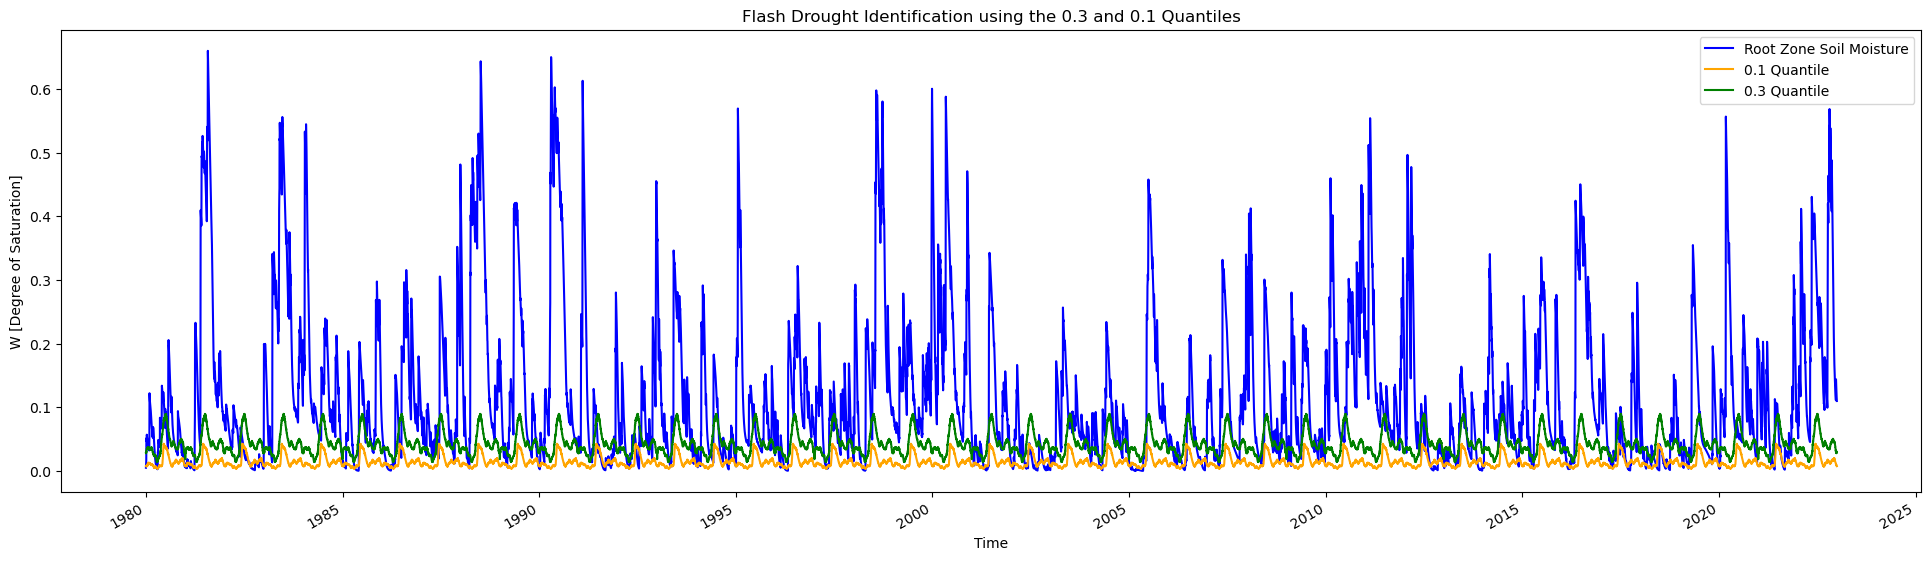

In [8]:
# using the built in plt for xarray, plotting a line plot with sm data, 0.1 and 0.3 quantile
da_sm['sm_pct'].plot( c = 'b', size = 6, aspect = 4, label = 'Root Zone Soil Moisture')
da_sm_10p.plot(c= 'orange', label = '0.1 Quantile')
da_sm_30p.plot(c = 'g', label = '0.3 Quantile')
plt.legend()
plt.title('Flash Drought Identification using the 0.3 and 0.1 Quantiles') 
plt.ylabel('W [Degree of Saturation]')
plt.xlabel('Time')

This plots the soil misture percentage (blue) against the 0.1th (orange) and 0.3th quantile (green). Showing seasonal variation in degree of saturation and the respective quantiles. 

In [9]:
# criteria 1 : SM above 30%

da_sm_gt_30p = da_sm['sm_pct'].where(da_sm['sm_pct'] >= da_sm_30p)

In [10]:
#criteria 2: SM has to drop below 10% within 20 days 
#in this code we check that it is below 10% after 20 days, but not in shorter periods

da_sm_lt_10p = da_sm['sm_pct'].where(da_sm['sm_pct'] <= da_sm_10p)
da_sm_after_20days_lt_10p = da_sm_lt_10p.shift(time = -20)

Text(0.5, 0, 'Time')

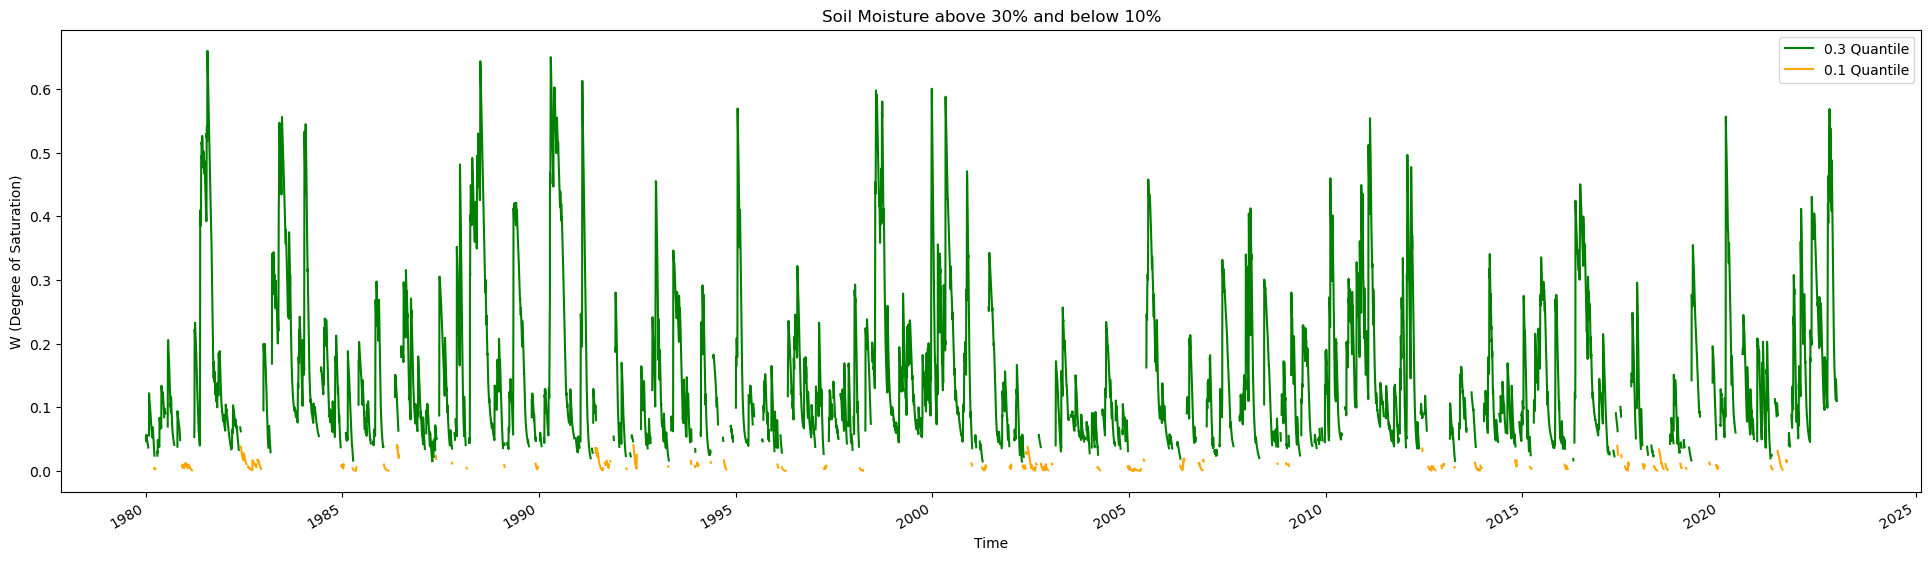

In [11]:
# plot of where soil moisture is above 30% and where it is below 10% after 20 days
da_sm_gt_30p.plot(size = 6, aspect = 4, color = 'g', label = '0.3 Quantile' )
da_sm_after_20days_lt_10p.plot(color= 'orange', label = '0.1 Quantile' )
plt.legend()
plt.title('Soil Moisture above 30% and below 10%') 
plt.ylabel('W (Degree of Saturation)')
plt.xlabel('Time')

This plot shows where the soil moisture is above 30% (green) and then is below 10%. The 0.1th quantile has been shifted 20 days forward, so that we now can check when we have values above the 0.3th quantile and below 0.1th 20 days later. 

In [12]:
da_sm_flash_drght = da_sm_gt_30p.where(~np.isnan(da_sm_after_20days_lt_10p)) 
#tilde ~ is a compliment operator, returning the "opposite" of what you specify
#Here it returns values that are not nan. So sm above 30% where sm is below 10% after 20 days

# check if there are any values
da_sm_flash_drght.dropna(dim = 'time') #dropna removes nan values

<xarray.DataArray 'sm_pct' (time: 135)>
array([0.0292502 , 0.02648648, 0.02398735, 0.02914911, 0.02641968,
       0.02393705, 0.02169181, 0.01965407, 0.01780352, 0.01613141,
       0.11037037, 0.10735161, 0.1035793 , 0.09898228, 0.09421571,
       0.09084804, 0.08815593, 0.08463714, 0.08086151, 0.0773858 ,
       0.07442457, 0.07135729, 0.06793399, 0.06317718, 0.06216186,
       0.05973329, 0.05712534, 0.04961425, 0.03684916, 0.03504958,
       0.04324097, 0.04045677, 0.05206224, 0.04686889, 0.10150708,
       0.09776247, 0.09473167, 0.09225991, 0.08871631, 0.08456253,
       0.07973193, 0.02234234, 0.0211221 , 0.05404818, 0.06547844,
       0.05987375, 0.05483922, 0.03447063, 0.03238623, 0.03009806,
       0.03571881, 0.06455544, 0.06001194, 0.05482731, 0.04957718,
       0.04482886, 0.04053402, 0.03668596, 0.02858921, 0.0558789 ,
       0.05239491, 0.04886519, 0.04542035, 0.04201486, 0.02166797,
       0.02017553, 0.01882728, 0.01759521, 0.01646345, 0.01588718,
       0.01502284, 0.04635224, 0.04298199, 0.04005364, 0.0367051 ,
       0.03327965, 0.03016348, 0.02820107, 0.02686305, 0.02520514,
       0.02361229, 0.0219233 , 0.03735682, 0.03787484, 0.03766994,
       0.03414223, 0.03095247, 0.02118413, 0.02061597, 0.01989288,
       0.01916786, 0.06305957, 0.05927726, 0.06444655, 0.05830887,
       0.05279508, 0.05483827, 0.04810746, 0.09169444, 0.08830043,
       0.0846758 , 0.02484208, 0.02297373, 0.05505667, 0.05122715,
       0.0475046 , 0.04641197, 0.04577542, 0.04354245, 0.04065729,
       0.03759532, 0.04478999, 0.04277178, 0.04050677, 0.03842709,
       0.04312023, 0.03927142, 0.04124987, 0.03801257, 0.03466259,
       0.06805034, 0.06559874, 0.06236954, 0.04270871, 0.04472833,
       0.04027328, 0.03642726, 0.05981808, 0.05463788, 0.04965908,
       0.02513073, 0.02411967, 0.09091791, 0.08740725, 0.08873468],
      dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-03-22 1980-03-23 ... 2021-07-01
    latitude   float64 -30.0
    longitude  float64 145.0
Attributes:
    name:           sm_pct
    units:          fraction of fullness
    long_name:      Total rootzone soil moisture (0-100 cm)
    standard_name:  sm_pct

Text(0.5, 0, 'Time')

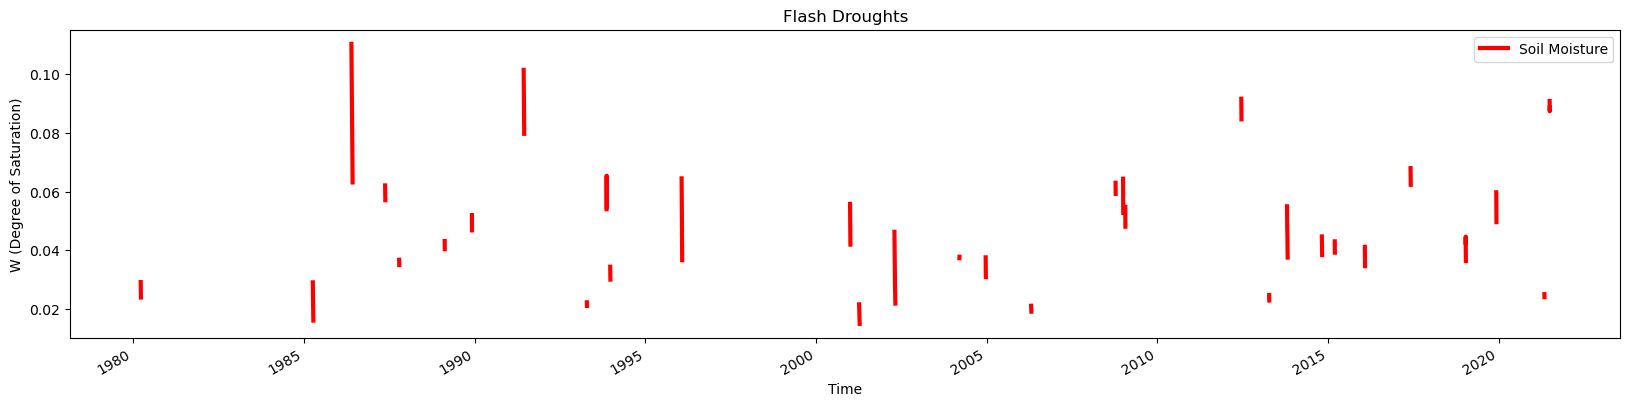

In [13]:
# plot of the flash drought events for a selected time slice 
da_sm_flash_drght.sel(time = time_slice).plot(size = 4, aspect= 5, linewidth = '3', linestyle = 'solid', c = 'r', label = 'Soil Moisture')
plt.legend()
plt.title('Flash Droughts') 
plt.ylabel('W (Degree of Saturation)')
plt.xlabel('Time')

This plot has now identified potential start dates for flash droughts. The "lines" indicate that we have multiple FD start dates in a row. Hopefully these can be filtered out using the next criteria. Below I have saved the above array as a netcdf file to be used for filtering more. It has nan-values for the days that are not considered potential FD start dates.

In [15]:
# save the calculated FD start day data to a netcdf file for future use

# first give some attributes 
da_sm_flash_drght.name = 'sm_pct'
da_sm_flash_drght.attrs['long_name'] = 'Total rootzone soil moisture (0-100 cm)'
da_sm_flash_drght.attrs['units'] = 'Fraction of fullness'

da_sm_flash_drght

out_dir = '/g/data/w97/aj8747/fd_summer_project/'
out_file = 'fd_sm_start.nc'
da_sm_flash_drght.to_netcdf(out_dir + out_file)

## FD end dates

In [16]:
fd_end = da_sm_flash_drght.shift( time = 20)

In [18]:
# save the calculated FD end day data to a netcdf file for future use

# first give some attributes 
fd_end.name = 'sm_pct'
fd_end.attrs['long_name'] = 'Total rootzone soil moisture (0-100 cm)'
fd_end.attrs['units'] = 'Fraction of fullness'

fd_end

out_dir = '/g/data/w97/aj8747/fd_summer_project/'
out_file = 'fd_sm_end_dates.nc'
fd_end.to_netcdf(out_dir + out_file)